# Clustering Crypto

In [144]:
# Initial imports
import requests
import pandas as pd
import matplotlib.pyplot as plt
import hvplot.pandas
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [145]:
# delete
# !pip install plotly-express


### additional imports

In [146]:
from pathlib import Path

### Fetching Cryptocurrency Data

In [147]:
# Use the following endpoint to fetch json data
url = "https://min-api.cryptocompare.com/data/all/coinlist"

In [148]:
# Create a DataFrame 
# HINT: You will need to use the 'Data' key from the json response, then transpose the DataFrame.

In [149]:
# Alternatively, use the provided csv file:
file_path = Path("Resources/crypto_data.csv")

# Create a DataFrame
df = pd.read_csv(file_path)

In [150]:
# df.columns

In [151]:
df.head(5)

,Unnamed: 0,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
0,42,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
1,365,365Coin,X11,True,PoW/PoS,NaN,2300000000
2,404,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
3,611,SixEleven,SHA-256,True,PoW,NaN,611000
4,808,808,SHA-256,True,PoW/PoS,0.000000e+00,0


### Data Preprocessing

In [152]:
# Keep only necessary columns:
# 'CoinName','Algorithm','IsTrading','ProofType','TotalCoinsMined','TotalCoinSupply'
df_test = df.iloc[: , 1:]
df_test.head(5)

,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
0,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
1,365Coin,X11,True,PoW/PoS,NaN,2300000000
2,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
3,SixEleven,SHA-256,True,PoW,NaN,611000
4,808,SHA-256,True,PoW/PoS,0.000000e+00,0


In [153]:
# Keep only cryptocurrencies that are trading
df_test = df_test [df_test['IsTrading'] == True]

In [154]:
df_test['Algorithm'].isnull().sum()

0

In [155]:
# Keep only cryptocurrencies with a working algorithm


In [156]:
# Remove the "IsTrading" column
df_test.drop('IsTrading', inplace = True, axis = 1)


In [157]:
df_test.isnull().sum()

CoinName             0
Algorithm            0
ProofType            0
TotalCoinsMined    459
TotalCoinSupply      0
dtype: int64

In [158]:
# Remove rows with at least 1 null value
df_test.dropna(inplace = True)
df_test.head()

,CoinName,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
0,42 Coin,Scrypt,PoW/PoS,4.199995e+01,42
2,404Coin,Scrypt,PoW/PoS,1.055185e+09,532000000
4,808,SHA-256,PoW/PoS,0.000000e+00,0
5,EliteCoin,X13,PoW/PoS,2.927942e+10,314159265359
7,Bitcoin,SHA-256,PoW,1.792718e+07,21000000


In [159]:
df_test.dtypes
# df['a'] = pd.to_numeric(df['a'],errors = 'coerce')
df_test['TotalCoinSupply'] = pd.to_numeric(df_test['TotalCoinSupply'] ,errors = 'coerce')
df_test.dtypes

CoinName            object
Algorithm           object
ProofType           object
TotalCoinsMined    float64
TotalCoinSupply    float64
dtype: object

In [163]:
# Remove rows with cryptocurrencies having no coins mined
df_test = df_test [df_test['TotalCoinSupply'] != 0]
df_test.head(5)

,CoinName,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
0,42 Coin,Scrypt,PoW/PoS,4.199995e+01,4.200000e+01
2,404Coin,Scrypt,PoW/PoS,1.055185e+09,5.320000e+08
5,EliteCoin,X13,PoW/PoS,2.927942e+10,3.141593e+11
7,Bitcoin,SHA-256,PoW,1.792718e+07,2.100000e+07
9,Litecoin,Scrypt,PoW,6.303924e+07,8.400000e+07


In [164]:
# create dataframe to add later
coin_df = df_test.copy()

In [161]:
# Drop rows where there are 'N/A' text values
# aldready done..???


In [212]:
# Store the 'CoinName'column in its own DataFrame prior to dropping it from crypto_df
coin_name = df_test.filter(['CoinName'], axis = 1)
# df_CoinName.column = ['CoinName']
coin_name.head()

,CoinName
0,42 Coin
2,404Coin
5,EliteCoin
7,Bitcoin
9,Litecoin


In [124]:
# Drop the 'CoinName' column since it's not going to be used on the clustering algorithm
df_test.drop(['CoinName'], axis = 1, inplace = True)
df_test.head()


,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
0,Scrypt,PoW/PoS,4.199995e+01,4.200000e+01
2,Scrypt,PoW/PoS,1.055185e+09,5.320000e+08
5,X13,PoW/PoS,2.927942e+10,3.141593e+11
7,SHA-256,PoW,1.792718e+07,2.100000e+07
9,Scrypt,PoW,6.303924e+07,8.400000e+07


In [126]:
# Create dummy variables for text features
# -- delete
# test = df_test.copy()
# # df.dtypes[df.dtypes == 'float64'].index.tolist()
# -- end delete
# # get a list of object types
obj_columns = df_test.dtypes[df_test.dtypes == 'object'].index.tolist()
# convert text columns to dummies
df_test = pd.get_dummies(df_test, columns= obj_columns)
df_test.head()

,TotalCoinsMined,TotalCoinSupply,Algorithm_1GB AES Pattern Search,Algorithm_536,Algorithm_Argon2,Algorithm_BLAKE256,Algorithm_Blake,Algorithm_Blake2S,Algorithm_Blake2b,Algorithm_C11,...,ProofType_PoW/PoS,ProofType_PoW/PoS,ProofType_PoW/PoW,ProofType_PoW/nPoS,ProofType_Pos,ProofType_Proof of Authority,ProofType_Proof of Trust,ProofType_TPoS,ProofType_Zero-Knowledge Proof,ProofType_dPoW/PoW
0,4.199995e+01,4.200000e+01,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,1.055185e+09,5.320000e+08,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
5,2.927942e+10,3.141593e+11,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
7,1.792718e+07,2.100000e+07,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,6.303924e+07,8.400000e+07,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [131]:
# Standardize data
# test = df_test.copy()
cryto_scaled = StandardScaler().fit_transform(df_test)
print(cryto_scaled[:1])


[[-0.09782131 -0.03965512 -0.03965258 -0.03965258 -0.03965258 -0.05612135
  -0.07949286 -0.03965258 -0.03965258 -0.05612135 -0.03965258 -0.03965258
  -0.18913582 -0.05612135 -0.03965258 -0.03965258 -0.07949286 -0.03965258
  -0.08894601 -0.06878853 -0.03965258 -0.03965258 -0.17052613 -0.03965258
  -0.03965258 -0.13856406 -0.03965258 -0.03965258 -0.06878853 -0.03965258
  -0.03965258 -0.03965258 -0.03965258 -0.06878853 -0.03965258 -0.07949286
  -0.08894601 -0.07949286 -0.03965258 -0.03965258 -0.11971303 -0.13255899
  -0.14433757 -0.03965258 -0.05612135 -0.03965258 -0.06878853 -0.17052613
  -0.03965258 -0.03965258 -0.03965258 -0.05612135 -0.18004141 -0.33998043
  -0.03965258 -0.08894601 -0.06878853 -0.05612135 -0.03965258  1.42090019
  -0.06878853 -0.03965258 -0.03965258 -0.06878853 -0.06878853 -0.03965258
  -0.03965258 -0.03965258 -0.03965258 -0.03965258 -0.03965258 -0.03965258
  -0.4108617  -0.03965258 -0.18004141 -0.03965258 -0.09751265 -0.07949286
  -0.09751265 -0.03965258 -0.03965258 

### Reducing Dimensions Using PCA

In [132]:
# Use PCA to reduce dimensions to 3 principal components
pca = PCA(n_components=3)
crypto_pca = pca.fit_transform(cryto_scaled)

In [141]:
# Create a DataFrame with the principal components data
# df_iris_pca = pd.DataFrame(
#     data=iris_pca, columns=["principal component 1", "principal component 2"]
# )
# df_iris_pca.head()
clustered_df = pd.DataFrame(
    data=crypto_pca, columns=["PC 1", "PC 2", "PC 3"]
)
df_crypto_pca.head()

,PC 1,PC 2,PC 3
0,-0.158738,1.194114,-0.502622
1,-0.144370,1.192410,-0.503154
2,0.422945,1.971415,-0.524873
3,-0.236922,-1.396870,0.179556
4,-0.318301,-1.065963,-0.051723


### Clustering Crytocurrencies Using K-Means

#### Find the Best Value for `k` Using the Elbow Curve

In [134]:
inertia = []
k = list(range(1, 11))

# Calculate the inertia for the range of k values
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(df_crypto_pca)
    inertia.append(km.inertia_)

# Create the Elbow Curve using hvPlot
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
df_elbow.hvplot.line(x="k", y="inertia", xticks=k, title="Elbow Curve")



C:\Users\Hassan\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  f"KMeans is known to have a memory leak on Windows "


:Curve   [k]   (inertia)

### HV plot did not work used normal plot

<AxesSubplot:xlabel='k'>

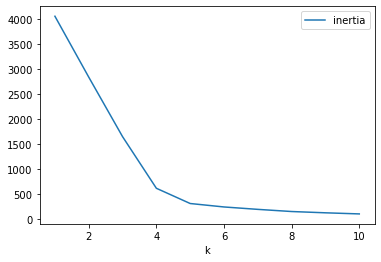

In [137]:
df_elbow.plot(x = 'k', y = 'inertia')

Running K-Means with `k=<your best value for k here>`

In [208]:
# Initialize the K-Means model
model = KMeans(n_clusters=4, random_state=0)
# Fit the model
model.fit(df_crypto_pca)
# Predict clusters
predictions = model.predict(df_crypto_pca)
# Create a new DataFrame including predicted clusters and cryptocurrencies features
df_crypto_pca["Class"] = model.labels_
df_crypto_pca.head()

,PC 1,PC 2,PC 3,class,Class
0,-0.158738,1.194114,-0.502622,0,0
1,-0.144370,1.192410,-0.503154,0,0
2,0.422945,1.971415,-0.524873,0,0
3,-0.236922,-1.396870,0.179556,1,1
4,-0.318301,-1.065963,-0.051723,1,1


In [209]:
# clustered_df = pd.concat ([coin_df, df_crypto_pca], join = 'outer')
# clustered_df.head()
clustered_df = coin_df.copy().dropna()

col_list = df_crypto_pca.columns.tolist()
for columnName in col_list:
    clustered_df[columnName] = df_crypto_pca[columnName]
clustered_df.head()


,CoinName,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply,PC 1,PC 2,PC 3,class,Class
0,42 Coin,Scrypt,PoW/PoS,4.199995e+01,4.200000e+01,-0.158738,1.194114,-0.502622,0.0,0.0
2,404Coin,Scrypt,PoW/PoS,1.055185e+09,5.320000e+08,0.422945,1.971415,-0.524873,0.0,0.0
5,EliteCoin,X13,PoW/PoS,2.927942e+10,3.141593e+11,-0.143718,1.497754,-0.392534,0.0,0.0
7,Bitcoin,SHA-256,PoW,1.792718e+07,2.100000e+07,-0.285340,-1.917873,0.415800,1.0,1.0
9,Litecoin,Scrypt,PoW,6.303924e+07,8.400000e+07,-0.138700,-1.732802,0.214999,1.0,1.0


### Visualizing Results

#### 3D-Scatter with Clusters

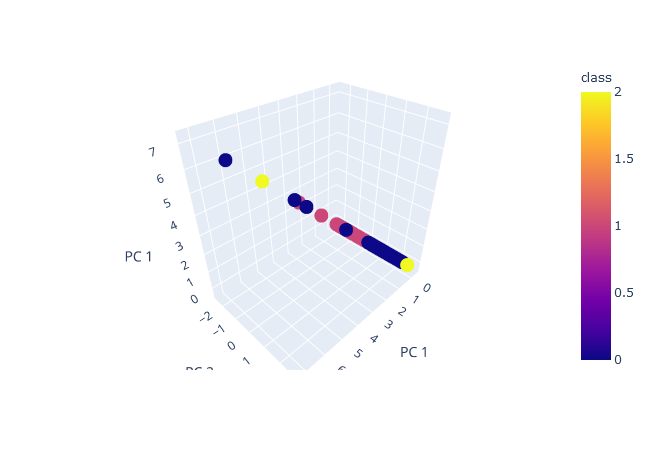

In [206]:
# Create a 3D-Scatter with the PCA data and the clusters
# fig = px.scatter_3d(
#     df_shopping_pca,
#     x="principal component 3",
#     y="principal component 2",
#     z="principal component 1",
#     color="class",
#     symbol="class",
#     width=800,
# )
# fig.update_layout(legend=dict(x=0, y=1))
# fig.show()
fig = px.scatter_3d(
    clustered_df,
    x="PC 1",
    y="PC 2",
    z="PC 1",
    color="Class",
#     symbol="class",
    hover_name="CoinName",
    hover_data=["Algorithm"],
    width=800,
)
fig.update_layout(legend=dict(x=0, y=1))
fig.show()

#### Table of Tradable Cryptocurrencies

In [210]:
# Table with tradable cryptos
# df.hvplot.table(columns=['origin', 'name', 'yr'], sortable=True, selectable=True)
col_list = ["CoinName", "Algorithm", "ProofType", "TotalCoinSupply", "TotalCoinsMined", "Class"]
clustered_df.hvplot.table(columns =col_list)

:Table   [CoinName,Algorithm,ProofType,TotalCoinSupply,TotalCoinsMined,Class]

In [ ]:
# Print the total number of tradable cryptocurrencies
print (f'Total Tradable Cr)

#### Scatter Plot with Tradable Cryptocurrencies

In [ ]:
# Scale data to create the scatter plot


In [ ]:
# Plot the scatter with x="TotalCoinsMined" and y="TotalCoinSupply"


## questions what are:
number of tradable cryptocurrencies
keep only the cryptocurrencies with a working algorithm.